# Github

In [2]:
import os
import torch
import numpy as np
import pickle
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

# %pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
# %pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
# %pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
# %pip install -q torch-cluster -f https://data.pyg.org/whl/torch-${TORCH}.html

from torch_geometric.datasets import GitHub
from torch_geometric.transforms import NormalizeFeatures


import os.path as osp
import matplotlib.pyplot as plt
import torch_geometric.transforms as T
from tqdm.notebook import tqdm

from torch_geometric.nn import GCNConv
import torch.nn.functional as F


2.1.1


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


## Stage 1: Train the base GNN model

In [4]:
transform = T.Compose([
    T.NormalizeFeatures(),
    T.ToDevice(device),
    T.RandomNodeSplit(num_val=0.1, num_test=0.1),
])

# Load the dataset
dataset = GitHub(root='/tmp/GitHub', transform=transform)
print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.
print(data)

print('==============================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Processing...
Done!



Dataset: GitHub():
Number of graphs: 1
Number of features: 128
Number of classes: 2
Data(x=[37700, 128], edge_index=[2, 578006], y=[37700], train_mask=[37700], val_mask=[37700], test_mask=[37700])
Number of nodes: 37700
Number of edges: 578006
Average node degree: 15.33
Number of training nodes: 30160
Training node label rate: 0.80
Has isolated nodes: False
Has self-loops: False
Is undirected: True


#### GCN model for Node Prediction

In [37]:
# train a GCN model for node classification
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(128, 64, cached=True,
                             normalize=True)
        # self.conv2 = GCNConv(64, 32, cached=True,
        #                      normalize=True)
        self.conv3 = GCNConv(64, 2, cached=True,
                             normalize=True)

    def forward(self, x, edge_index, edge_weight=None):
        x = self.conv1(x, edge_index, edge_weight).relu()
        # x = F.dropout(x, p=0.4, training=self.training)
        # x = self.conv2(x, edge_index, edge_weight).relu()
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.conv3(x, edge_index, edge_weight)
        return x

In [38]:
GNNmodel = GCN()
GNNmodel, data = GNNmodel.to(device), data.to(device)
optimizer = torch.optim.Adam(GNNmodel.parameters(), weight_decay=1e-4, lr=0.03)
n_epoch=1000
print(GNNmodel)

GCN(
  (conv1): GCNConv(128, 64)
  (conv3): GCNConv(64, 2)
)


In [39]:
def train():
    GNNmodel.train()
    optimizer.zero_grad()
    out = GNNmodel(data.x, data.edge_index)
    loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return float(loss)

@torch.no_grad()
def test():
    GNNmodel.eval()
    pred = GNNmodel(data.x, data.edge_index).argmax(dim=-1)
    mask_val = data.val_mask
    mask_test = data.test_mask
    accs_val = (int((pred[mask_val] == data.y[mask_val]).sum()) / int(mask_val.sum()))
    accs_test = (int((pred[mask_test] == data.y[mask_test]).sum()) / int(mask_test.sum()))
    return accs_val, accs_test

In [40]:
loss_record = []
val_acc_record = []
test_acc_record = []

for epoch in range(1, n_epoch):
    loss = train()
    val_acc, test_acc= test()
    
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, '
          f'Val: {val_acc:.4f}, Test: {test_acc:.4f}')
    
    loss_record.append(loss)
    val_acc_record.append(val_acc)
    test_acc_record.append(test_acc)

Epoch: 001, Loss: 0.6888, Val: 0.7334, Test: 0.7562
Epoch: 002, Loss: 0.6142, Val: 0.7334, Test: 0.7562
Epoch: 003, Loss: 0.5791, Val: 0.7334, Test: 0.7562
Epoch: 004, Loss: 0.5985, Val: 0.7334, Test: 0.7562
Epoch: 005, Loss: 0.6031, Val: 0.7334, Test: 0.7562
Epoch: 006, Loss: 0.5888, Val: 0.7334, Test: 0.7562
Epoch: 007, Loss: 0.5774, Val: 0.7334, Test: 0.7562
Epoch: 008, Loss: 0.5745, Val: 0.7334, Test: 0.7562
Epoch: 009, Loss: 0.5777, Val: 0.7334, Test: 0.7562
Epoch: 010, Loss: 0.5786, Val: 0.7334, Test: 0.7562
Epoch: 011, Loss: 0.5782, Val: 0.7334, Test: 0.7562
Epoch: 012, Loss: 0.5737, Val: 0.7334, Test: 0.7562
Epoch: 013, Loss: 0.5712, Val: 0.7334, Test: 0.7562
Epoch: 014, Loss: 0.5695, Val: 0.7334, Test: 0.7562
Epoch: 015, Loss: 0.5686, Val: 0.7334, Test: 0.7562
Epoch: 016, Loss: 0.5683, Val: 0.7334, Test: 0.7562
Epoch: 017, Loss: 0.5689, Val: 0.7334, Test: 0.7562
Epoch: 018, Loss: 0.5674, Val: 0.7334, Test: 0.7562
Epoch: 019, Loss: 0.5662, Val: 0.7334, Test: 0.7562
Epoch: 020, 

In [43]:
# 儲存模型
torch.save(GNNmodel, './models/Github/1_GCN_model.pt')

# 匯入模型
# GNNmodel = torch.load('./models/Github/1_GCN_model.pt')

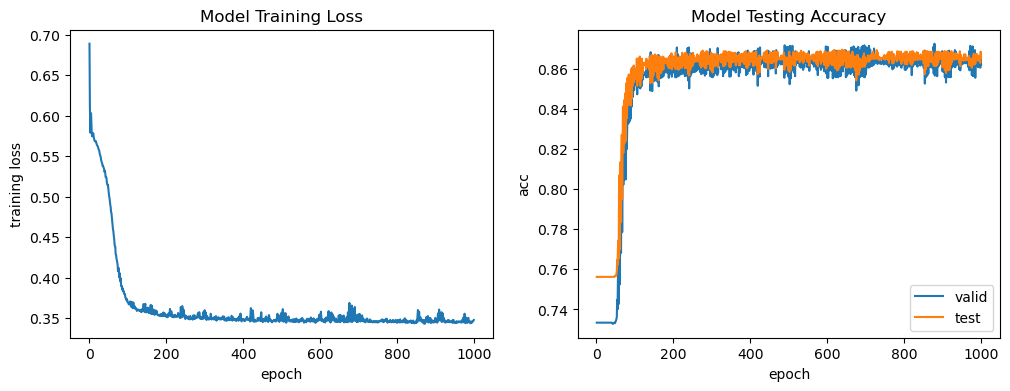

In [44]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(range(1, n_epoch), loss_record)
plt.xlabel("epoch")
plt.ylabel("training loss")
plt.title(f"Model Training Loss")


plt.subplot(1,2,2)
plt.plot(range(1, n_epoch), val_acc_record, label='valid')
plt.plot(range(1, n_epoch), test_acc_record, label='test')
plt.legend()
plt.xlabel("epoch")
plt.ylabel("acc")
plt.title(f"Model Testing Accuracy")
plt.savefig('./plot/Github/1_GCNresult.png', dpi=300)

plt.show()

## Stage 2: Use GNNExplainer to obtain subgraph explanations

#### Generate subgraph by GNNExplainer 

We also support many different types of masks, these are set with `node_mask_type` and `edge_mask_type`, and can be:

None will not mask any nodes/edges  
`"object"` will mask each node/edge  
`"common_attributes"` will mask each node feature/edge attribute  
`"attributes"` will mask each node feature/edge attribute separately across all nodes/edges  

In [45]:
from torch_geometric.explain import Explainer, GNNExplainer

# set up explainer
# hops = 3
explainer = Explainer(
    model=GNNmodel,
    algorithm=GNNExplainer(epochs=200, num_hops=2),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='multiclass_classification',
        task_level='node',
        return_type='log_probs',
    ),
)

In [46]:
# 匯入 module.py
from importlib import reload
import module
reload(module) 

<module 'module' from '/Users/liang/Documents/NCKU_DS/圖機器學習專討/final/module.py'>

#### Build a dataset with train, valid, test
p.s. 後續只使用 train:100, valid:20, test:20

In [47]:
num = 400
dataset_train = []
for i in tqdm(range(num)):
    d = module.SubgraphData(data, explainer, k=3, train=True)
    dd = d.get_data()
    dataset_train.append(dd)

with open('./dataset/Github/dataset_train.pickle', 'wb') as file:
    pickle.dump(dataset_train, file)
print("已將 dataset_train 存至 ./dataset/Github/dataset_train.pickle")

# 只生成250個 跑了1547分鐘...

  0%|          | 0/400 [00:00<?, ?it/s]

GNNExplainer 生成子圖中...
子圖生成完畢
3個子圖的所有節點，在原圖中存在路徑!
GNNExplainer 生成子圖中...
子圖生成完畢
3個子圖的所有節點，在原圖中存在路徑!
GNNExplainer 生成子圖中...
子圖生成完畢
3個子圖的所有節點，在原圖中存在路徑!
GNNExplainer 生成子圖中...
子圖生成完畢
3個子圖的所有節點，在原圖中存在路徑!
GNNExplainer 生成子圖中...
子圖生成完畢
3個子圖的所有節點，在原圖中存在路徑!
GNNExplainer 生成子圖中...
子圖生成完畢
3個子圖的所有節點，在原圖中存在路徑!
GNNExplainer 生成子圖中...
子圖生成完畢
3個子圖的所有節點，在原圖中存在路徑!
GNNExplainer 生成子圖中...
子圖生成完畢
3個子圖的所有節點，在原圖中存在路徑!
GNNExplainer 生成子圖中...
子圖生成完畢
3個子圖的所有節點，在原圖中存在路徑!
GNNExplainer 生成子圖中...
子圖生成完畢
3個子圖的所有節點，在原圖中存在路徑!
GNNExplainer 生成子圖中...
子圖生成完畢
3個子圖的所有節點，在原圖中存在路徑!
GNNExplainer 生成子圖中...
子圖生成完畢
3個子圖的所有節點，在原圖中存在路徑!
GNNExplainer 生成子圖中...
子圖生成完畢
3個子圖的所有節點，在原圖中存在路徑!
GNNExplainer 生成子圖中...
子圖生成完畢
3個子圖的所有節點，在原圖中存在路徑!
GNNExplainer 生成子圖中...
子圖生成完畢
3個子圖的所有節點，在原圖中存在路徑!
GNNExplainer 生成子圖中...
子圖生成完畢
3個子圖的所有節點，在原圖中存在路徑!
GNNExplainer 生成子圖中...
子圖生成完畢
3個子圖的所有節點，在原圖中存在路徑!
GNNExplainer 生成子圖中...
子圖生成完畢
3個子圖的所有節點，在原圖中存在路徑!
GNNExplainer 生成子圖中...
子圖生成完畢
3個子圖的所有節點，在原圖中存在路徑!
GNNExplainer 生成子圖中...
子圖生成完畢
3個子圖的所有節點，在原圖中存在路徑!
GNNExplainer 生成子圖中..

KeyboardInterrupt: 

In [50]:
num = 20
dataset_valid = []
for i in tqdm(range(num)):
    d = module.SubgraphData(data, explainer, k=3, train=False)
    dd = d.get_data()
    dataset_valid.append(dd)

with open('./dataset/Github/dataset_valid.pickle', 'wb') as file:
    pickle.dump(dataset_valid, file)
print("已將 dataset_valid 存至 ./dataset/Github/dataset_valid.pickle")

  0%|          | 0/20 [00:00<?, ?it/s]

GNNExplainer 生成子圖中...
子圖生成完畢
3個子圖的所有節點，在原圖中存在路徑!
GNNExplainer 生成子圖中...
子圖生成完畢
3個子圖的所有節點，在原圖中存在路徑!
GNNExplainer 生成子圖中...
子圖生成完畢
3個子圖的所有節點，在原圖中存在路徑!
GNNExplainer 生成子圖中...
子圖生成完畢
3個子圖的所有節點，在原圖中存在路徑!
GNNExplainer 生成子圖中...
子圖生成完畢
3個子圖的所有節點，在原圖中存在路徑!
GNNExplainer 生成子圖中...
子圖生成完畢
3個子圖的所有節點，在原圖中存在路徑!
GNNExplainer 生成子圖中...
子圖生成完畢
3個子圖的所有節點，在原圖中存在路徑!
GNNExplainer 生成子圖中...
子圖生成完畢
3個子圖的所有節點，在原圖中存在路徑!
GNNExplainer 生成子圖中...
子圖生成完畢
3個子圖的所有節點，在原圖中存在路徑!
GNNExplainer 生成子圖中...
子圖生成完畢
3個子圖的所有節點，在原圖中存在路徑!
GNNExplainer 生成子圖中...
子圖生成完畢
3個子圖的所有節點，在原圖中存在路徑!
GNNExplainer 生成子圖中...
子圖生成完畢
3個子圖的所有節點，在原圖中存在路徑!
GNNExplainer 生成子圖中...
子圖生成完畢
3個子圖的所有節點，在原圖中存在路徑!
GNNExplainer 生成子圖中...
子圖生成完畢
3個子圖的所有節點，在原圖中存在路徑!
GNNExplainer 生成子圖中...
子圖生成完畢
3個子圖的所有節點，在原圖中存在路徑!
GNNExplainer 生成子圖中...
子圖生成完畢
3個子圖的所有節點，在原圖中存在路徑!
GNNExplainer 生成子圖中...
子圖生成完畢
3個子圖的所有節點，在原圖中存在路徑!
GNNExplainer 生成子圖中...
子圖生成完畢
3個子圖的所有節點，在原圖中存在路徑!
GNNExplainer 生成子圖中...
子圖生成完畢
3個子圖的所有節點，在原圖中存在路徑!
GNNExplainer 生成子圖中...
子圖生成完畢
3個子圖的所有節點，在原圖中存在路徑!
已將 dataset_valid5 存至

In [51]:
num = 20
dataset_test = []
for i in tqdm(range(num)):
    d = module.SubgraphData(data, explainer, k=3, train=False)
    dd = d.get_data()
    dataset_test.append(dd)

with open('./dataset/Github/dataset_test.pickle', 'wb') as file:
    pickle.dump(dataset_test, file)
print("已將 dataset_test 存至 ./dataset/Github/dataset_test.pickle")


  0%|          | 0/20 [00:00<?, ?it/s]

GNNExplainer 生成子圖中...
子圖生成完畢
3個子圖的所有節點，在原圖中存在路徑!
GNNExplainer 生成子圖中...
子圖生成完畢
3個子圖的所有節點，在原圖中存在路徑!
GNNExplainer 生成子圖中...
子圖生成完畢
3個子圖的所有節點，在原圖中存在路徑!
GNNExplainer 生成子圖中...
子圖生成完畢
3個子圖的所有節點，在原圖中存在路徑!
GNNExplainer 生成子圖中...
子圖生成完畢
3個子圖的所有節點，在原圖中存在路徑!
GNNExplainer 生成子圖中...
子圖生成完畢
3個子圖的所有節點，在原圖中存在路徑!
GNNExplainer 生成子圖中...
子圖生成完畢
3個子圖的所有節點，在原圖中存在路徑!
GNNExplainer 生成子圖中...
子圖生成完畢
3個子圖的所有節點，在原圖中存在路徑!
GNNExplainer 生成子圖中...
子圖生成完畢
3個子圖的所有節點，在原圖中存在路徑!
GNNExplainer 生成子圖中...
子圖生成完畢
3個子圖的所有節點，在原圖中存在路徑!
GNNExplainer 生成子圖中...
子圖生成完畢
3個子圖的所有節點，在原圖中存在路徑!
GNNExplainer 生成子圖中...
子圖生成完畢
3個子圖的所有節點，在原圖中存在路徑!
GNNExplainer 生成子圖中...
子圖生成完畢
3個子圖的所有節點，在原圖中存在路徑!
GNNExplainer 生成子圖中...
子圖生成完畢
3個子圖的所有節點，在原圖中存在路徑!
GNNExplainer 生成子圖中...
子圖生成完畢
3個子圖的所有節點，在原圖中存在路徑!
GNNExplainer 生成子圖中...
子圖生成完畢
3個子圖的所有節點，在原圖中存在路徑!
GNNExplainer 生成子圖中...
子圖生成完畢
3個子圖的所有節點，在原圖中存在路徑!
GNNExplainer 生成子圖中...
子圖生成完畢
3個子圖的所有節點，在原圖中存在路徑!
GNNExplainer 生成子圖中...
子圖生成完畢
3個子圖的所有節點，在原圖中存在路徑!
GNNExplainer 生成子圖中...
子圖生成完畢
3個子圖的所有節點，在原圖中存在路徑!
已將 dataset_test3 存至 